##  Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller

from catboost import Pool, CatBoostRegressor, cv
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Чтение файла

In [2]:
data = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])

Знакомство с данными

In [3]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


## Анализ

Выполним их ресемплирование по одному часу

Text(0, 0.5, 'Количество')

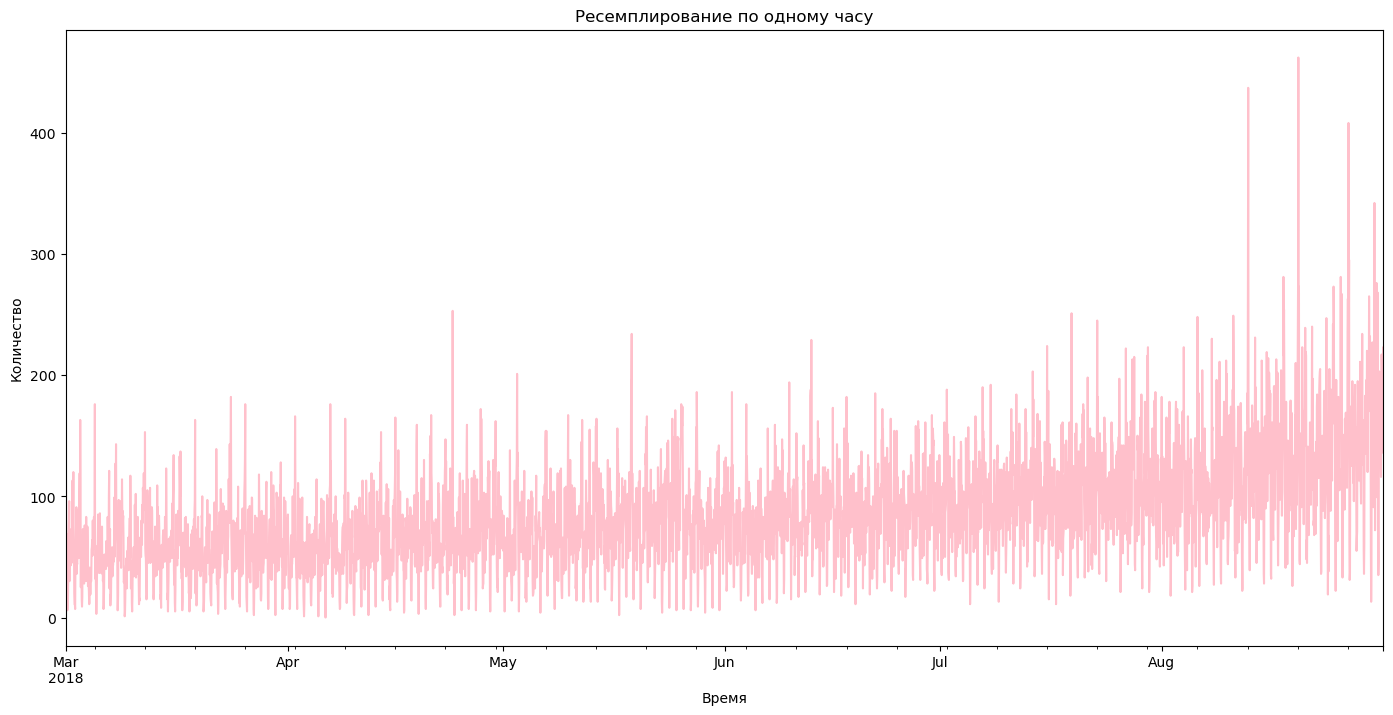

In [6]:
data = data.resample('1H').sum()
data.plot(figsize=(17,8), title = 'Ресемплирование по одному часу', color='pink', legend=False)
plt.xlabel("Время")
plt.ylabel("Количество")

Посмторим на тренд, сезонность и остаток декомпозиции за все время

За все время


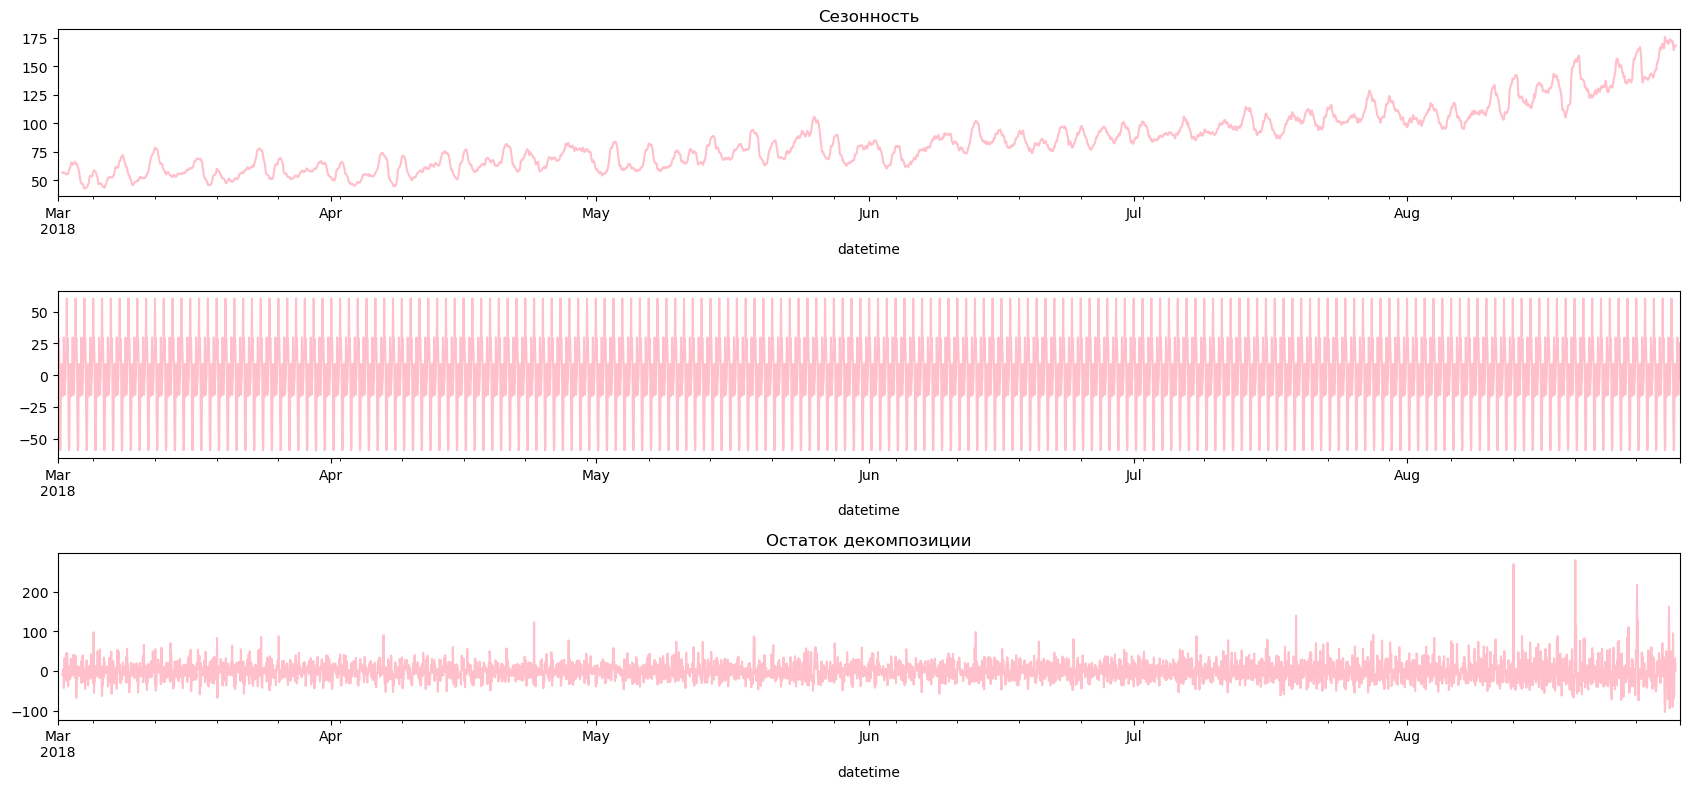

In [9]:
print('За все время')
decomposed = seasonal_decompose(data)
plt.figure(figsize=(17,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='pink')
plt.title('Тренд')
plt.title('Сезонность')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='pink')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='pink')
plt.title('Остаток декомпозиции')
plt.tight_layout()

Посмторим на тренд, сезонность и остаток декомпозиции за последний месяц

За последний месяц


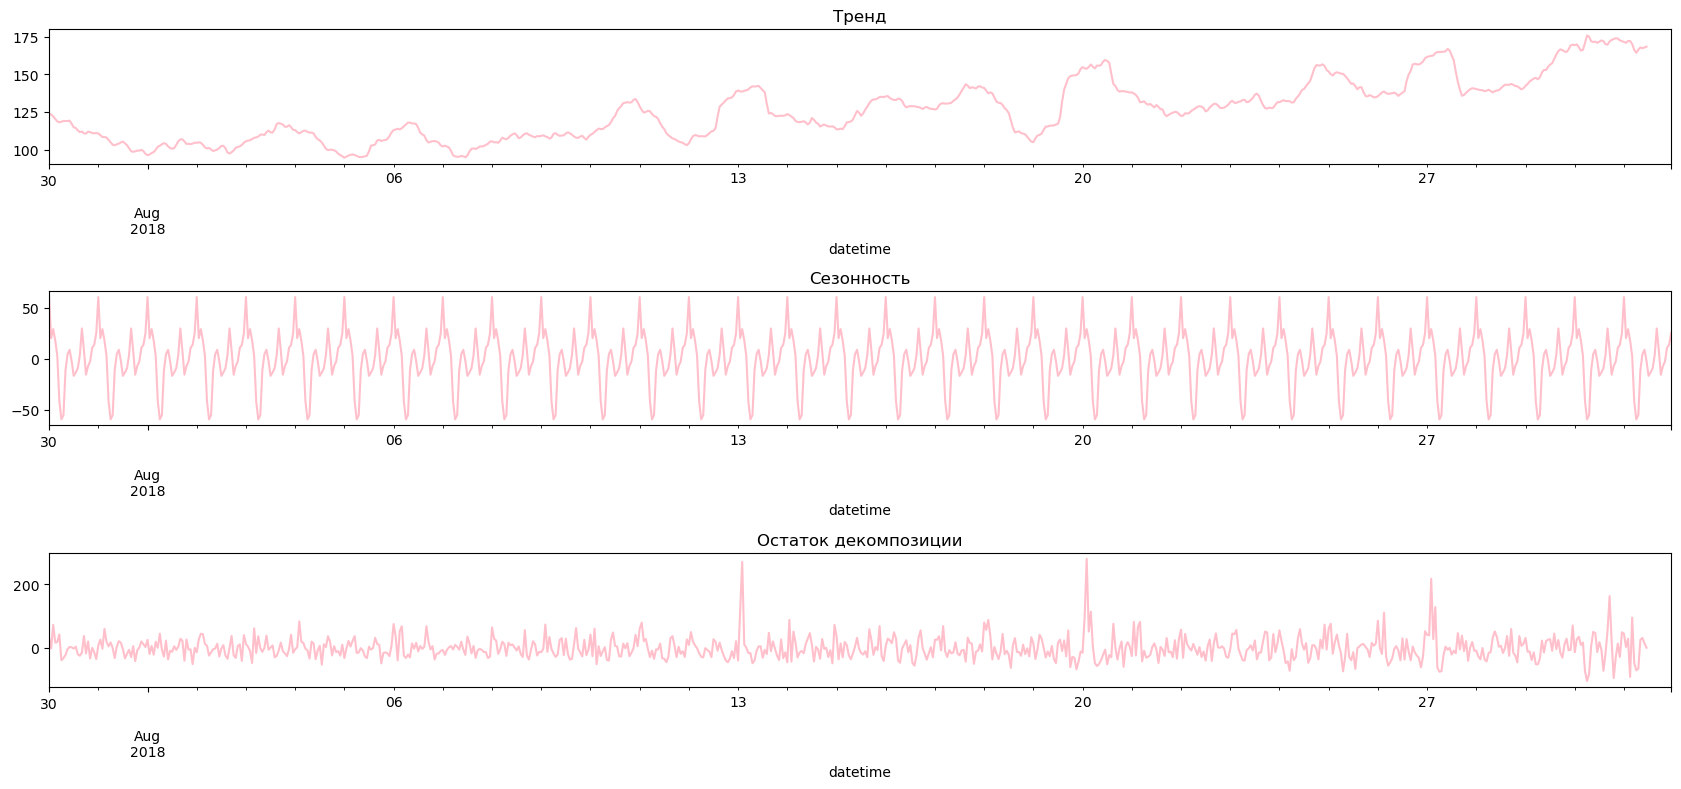

In [8]:
print('За последний месяц')
plt.figure(figsize=(17,8)) 
plt.subplot(311)
decomposed.trend['2018-07-30':'2018-08-31'].plot(ax=plt.gca(), color='pink')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-07-30':'2018-08-31'].plot(ax=plt.gca(), color='pink')
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-07-30':'2018-08-31'].plot(ax=plt.gca(), color='pink')
plt.title('Остаток декомпозиции')
plt.tight_layout()

Посмторим на тренд, сезонность и остаток декомпозиции за неделю

За неделю


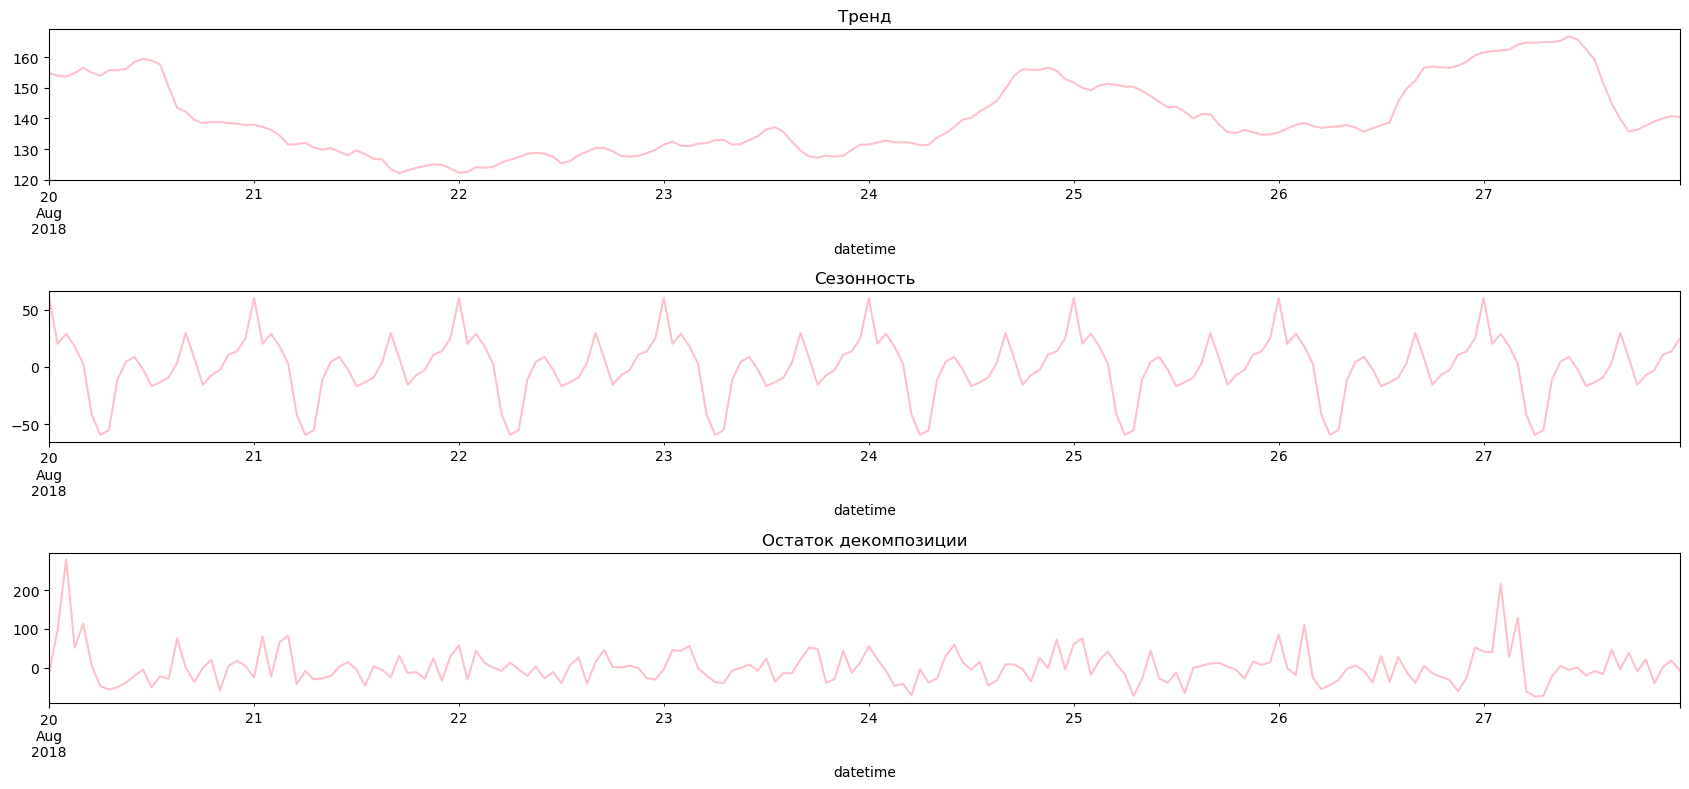

In [10]:
print('За неделю')
plt.figure(figsize=(17,8)) 
plt.subplot(311)
decomposed.trend['2018-08-20':'2018-08-27'].plot(ax=plt.gca(), color='pink')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-08-20':'2018-08-27'].plot(ax=plt.gca(), color='pink')
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-08-20':'2018-08-27'].plot(ax=plt.gca(), color='pink')
plt.title('Остаток декомпозиции')
plt.tight_layout()

Посмторим на тренд, сезонность и остаток декомпозиции за последние сутки

За сутки


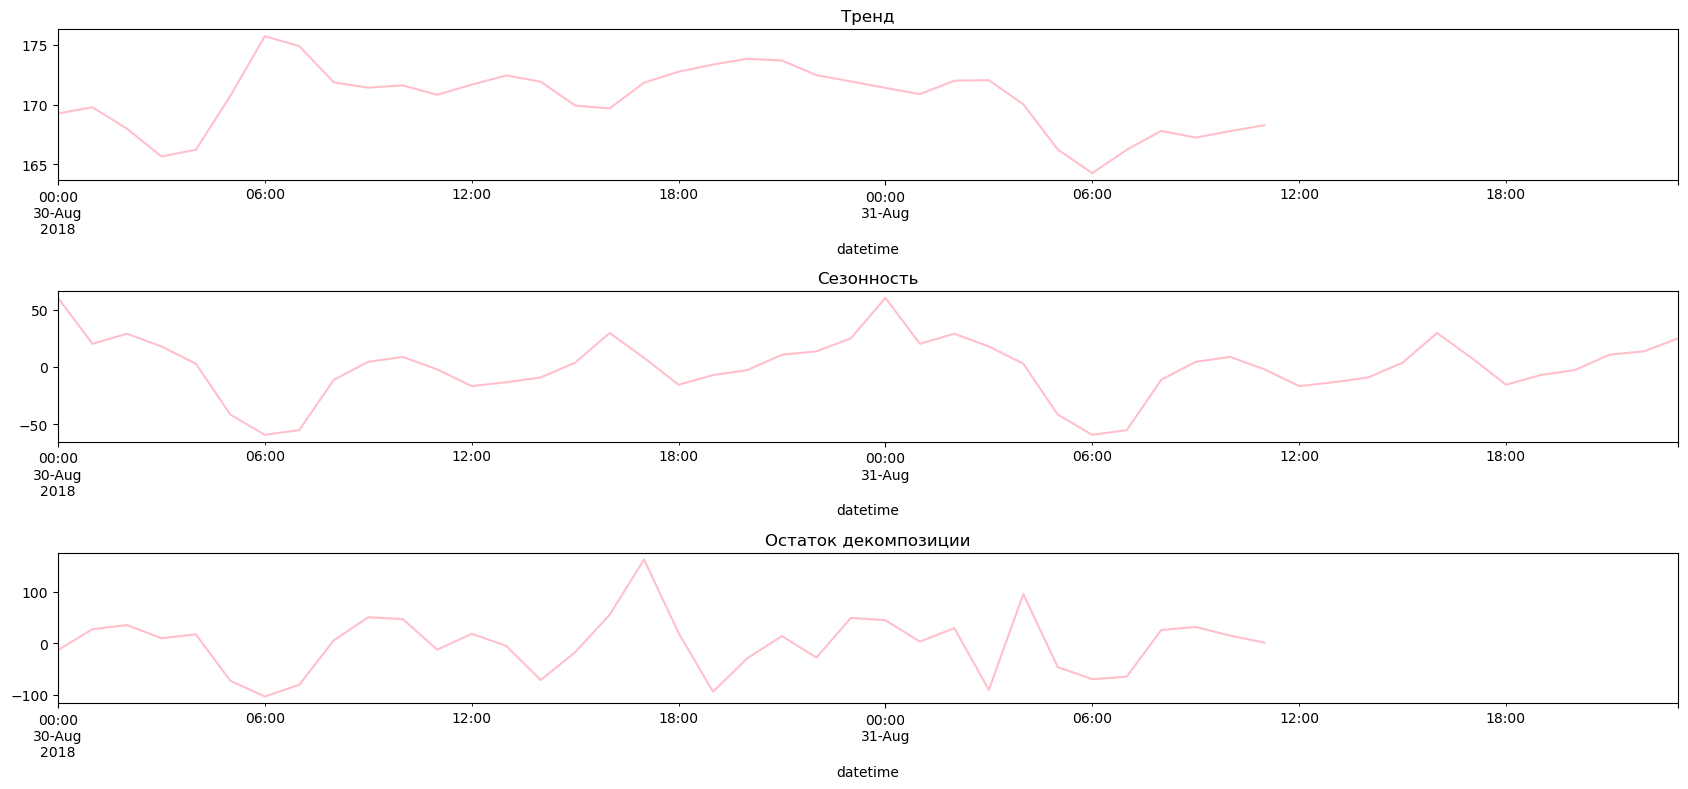

In [11]:
print('За сутки')
plt.figure(figsize=(17,8)) 
plt.subplot(311)
decomposed.trend['2018-08-30':'2018-08-31'].plot(ax=plt.gca(), color='pink')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca(), color='pink')
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-08-30':'2018-08-31'].plot(ax=plt.gca(), color='pink')
plt.title('Остаток декомпозиции')
plt.tight_layout()

**Вывод**  
Трендевоые изменения присутствуют как в годовом графике и недельном, так и суточном.  
Например, явно наблюдается рост заказов с марта по август. Конец августа - пик по количеству заказов за весь год.   
В месяце ситуация меняется от неделе к неделе, но наблюдается общий рост заказов к концу месяца.   
В неделе ситуация также меняется от дня ко дню. Пик по заказам приходится на утро понедельника. Самые низкие показатели у вторника, среды и четверга. К выходным количество заказов увеличивается.   
Втечение суток самое большое количество заказов приходится на утро (06:00), днем количество заказов уменьшается, а к вечеру увеличивается. Важно отметить, что спрос на такси в ночное время тоже присутствует.   


## Подготовка данных

Тут я поделюсь тем, как я два дня подряд подбирала max_lag, rolling_mean_size.
С самого начала исходя из логических рассуждений была написана простая функция для вычисления этих параметров,которые в итоге и использовались,НО дальше я почему то решила разделить данные на три выборки по всем канонам, не подумав о том, что обучающая выборка пострадает. Ничего не получалось. Тогда я написала функцию (см ниже), которая подбирает параметры для модели и все вроде сложилось хорошо, но я все таки решила избавиться от валидационной выборки в пользу обучающей и все оказалось намного проще. Для одной из моделей RMSE оказался ниже необходимого уровня, что и нужно было для заказчика. Но если вдруг понадобиться улучшить результаты, то можно воспользоваться функцией ниже.

Исследуем, какие признаки нам понадобится.

Для определения количество lag признаков найдем разницу в часах между максимальным и минимальным количеством заказов за сутки.

In [12]:
decomposed_data = seasonal_decompose(data['2018-08-29':'2018-08-30'])
max_lag = ((decomposed_data.seasonal.idxmax() - decomposed_data.seasonal.idxmin())// np.timedelta64(1, 'h'))
max_lag

17

Так же попробуем найти ширину окна rolling_mean

In [13]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,100):
    data_rm = data['2018-03-29':'2018-08-30'].copy()
    data_rm['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data_rm.dropna(inplace=True)
    index = data.index
    num_orders = data_rm['num_orders']
    rolling_mean = data_rm['rolling_mean']
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    rolling_mean_size_dict[rolling_mean_size] = RMSE

In [14]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

2

Так как наблюдается сезонность по году, дню неделю и суткам, то добавим в признаки day, dayofweek, month.

In [15]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(data,'num_orders', max_lag, rolling_mean_size)

Теперь разделим данные на две выборки в соотношении 9/1

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=1515)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

**Вывод**  
Добавили признаки и разделили данные на две выборки

## Обучение

Подберем гиперпараметры для моделей

Модель дерева решений

In [19]:
my_cv = TimeSeriesSplit(n_splits=8)
model = DecisionTreeRegressor() 
max_depth = [x for x in range(2, 30)]
params = [{'criterion':['squared_error'], 
                'max_depth':max_depth, 
                'random_state':[12345]}]

clf = GridSearchCV(estimator=model, param_grid = params, cv = my_cv, n_jobs=-1, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters:")
print(clf.best_params_)

RMSE_DTR = ((clf.cv_results_['mean_test_score']).mean()*-1) ** 0.5
time_DTR = clf.cv_results_['mean_fit_time'].mean()
print("RMSE:", RMSE_DTR)

Best parameters:
{'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
RMSE: 36.61453405552464


Модель градиентного бустинга

In [20]:
model = CatBoostRegressor()
params = [{'learning_rate':[0.1, 0.2, 0.5],
                'random_state':[12345],
                'verbose':[False], 
           'max_depth': [1,6]}]
clf = GridSearchCV(estimator=model, param_grid = params, cv = my_cv, n_jobs=-1 , scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters:")
print(clf.best_params_)

RMSE_CBR = ((clf.cv_results_['mean_test_score']).mean()*-1) ** 0.5
time_CBR = clf.cv_results_['mean_fit_time'].mean()
print("RMSE:", RMSE_CBR)

Best parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'random_state': 12345, 'verbose': False}
RMSE: 29.806110715905856


LGBM модель

In [21]:
model = lgb.LGBMRegressor() 
params = [{'learning_rate':[0.1, 0.2, 0.5, 0.8],
                'random_state':[12345]}]

clf = GridSearchCV(estimator=model, param_grid =params, cv = my_cv, n_jobs=-1 , scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print("Best parameters:")
print(clf.best_params_)

RMSE_LGBM = ((clf.cv_results_['mean_test_score']).mean()*-1) ** 0.5
time_LGBM = clf.cv_results_['mean_fit_time'].mean()
print("RMSE:", RMSE_LGBM)

Best parameters:
{'learning_rate': 0.1, 'random_state': 12345}
RMSE: 30.32377529400931


In [22]:
index = ['DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на обучающей выборке':[RMSE_DTR, RMSE_CBR, RMSE_LGBM],
        'Время обучения модели, сек':[time_DTR, time_CBR, time_LGBM]}

scores_data = pd.DataFrame(data=data, index=index)

In [23]:
scores_data

,RMSE на обучающей выборке,"Время обучения модели, сек"
DecisionTreeRegressor,36.614534,0.022159
CatBoostRegressor,29.806111,1.802571
LGBMRegressor,30.323775,0.077144


**Вывод:**  
По RMSE выигрывает модель градиентного бустинга, но по времени обучения лучше всего себя показало дерево решений. Исходя из того, что для нас предпочтительнее не скорость, а результат остановимся на модели градиентного бустинга.

## Тестирование

In [24]:
%%time

model = CatBoostRegressor(depth=6,
                          learning_rate=0.1, 
                          random_state=12345, 
                          verbose=False) 
model.fit(features_train, target_train)

CPU times: user 4.27 s, sys: 1.2 s, total: 5.47 s
Wall time: 1.26 s


In [25]:
%%time

target_predict = model.predict(features_test)

CPU times: user 2.29 ms, sys: 1.63 ms, total: 3.91 ms
Wall time: 2.57 ms


In [26]:
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5  
final_RMSE_CBR

47.03577668975245

Text(0.5, 0, 'Дата')

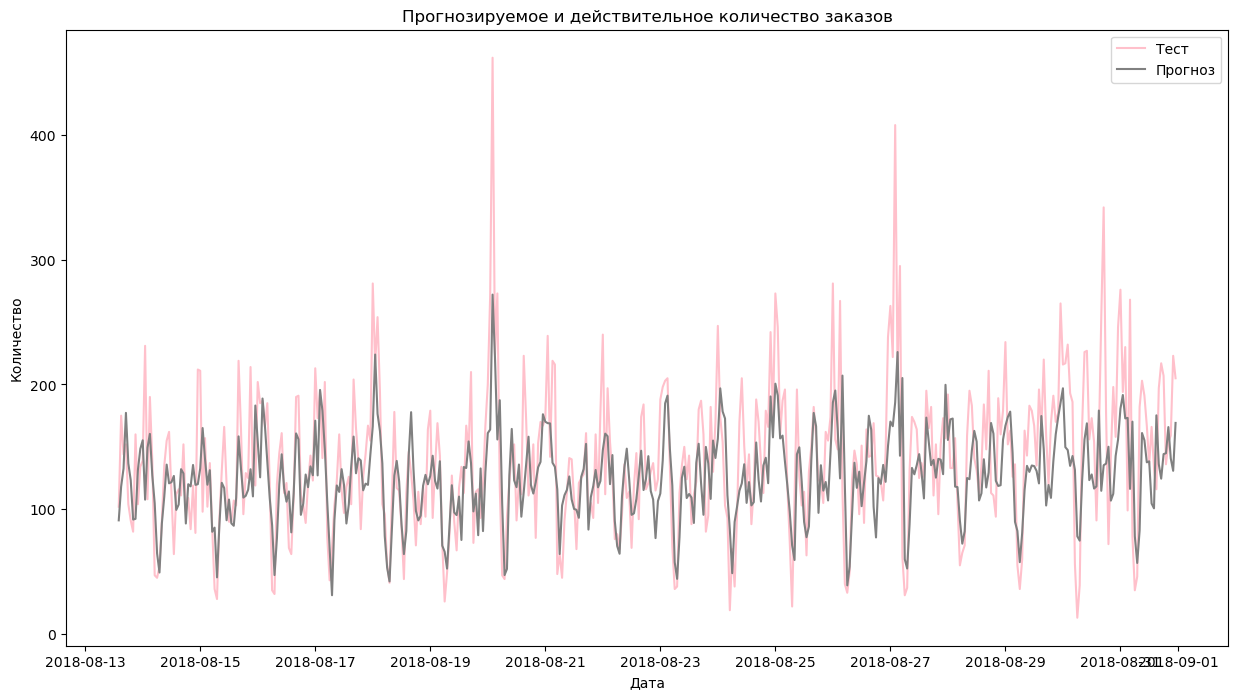

In [37]:
plt.figure(figsize=(15,8))
plt.plot(target_test.index, target_test, 'pink', label='Тест')
plt.plot(target_test.index, target_predict, 'grey', label='Прогноз')
plt.legend()
plt.title('Прогнозируемое и действительное количество заказов')
plt.ylabel("Количество")
plt.xlabel("Дата")

## Вывод

 По итоговому рейтингу времени обучения/предсказания и метрики RMSE побеждает DecisionTreeRegressor, но я считаю нужным назначить лидером CatBoostRegressor, так как в данном случае качество предсказания куда важнее времени обучения. DecisionTreeRegressor в этом плане сильно проигрывает другим моделям.  
Поэтому победителем нашего вечера назначается:  
- Модель: CatBoostRegressor;  
- Гиперпараметры: depth=6, learning_rate=0.1, random_state=12345, verbose=False;   
- RMSE на тестовой выборке: 47.03577;  
- Время обучения, сек: 1.26;  
- Время предсказания модели, мсек: 2.57.